<a href="https://colab.research.google.com/github/melisailknur/melisailknur/blob/main/technet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
BATCH_SIZE = 26
IMG_SIZE = 224

# Loading dataset

In [4]:
PATH_TO_PROJECT = "/content/drive/MyDrive/technet"
PATH_TO_IMAGES = "/content/sample_data/dataset-resized"

In [6]:
!ls /content/drive/MyDrive/technet

dataset-resized.zip


In [ ]:
if not os.path.isdir("/content/sample_data/dataset-resized"):
    !unzip /content/drive/MyDrive/technet/dataset-resized.zip -d /content/sample_data/

# Data preprocessing

In [ ]:
len(os.listdir(PATH_TO_IMAGES))

In [ ]:
all_images = glob.glob(PATH_TO_IMAGES+"/*/*.jpg")

In [ ]:
img_path = all_images[7]
img_path

In [ ]:
img = cv2.imread(img_path)

In [ ]:
img.shape

In [ ]:
px.imshow(img)

In [ ]:
all_classes = [imgpath.split('/')[-2] for imgpath in all_images]
all_classes_names = list(set(all_classes))
all_classes_count = []
for class_name in all_classes_names:
    all_classes_count.append(all_classes.count(class_name))

In [ ]:
px.bar(x=all_classes_names, y=all_classes_count)

For trash images, we can rotate, mirror, zoom..

In [ ]:
NUM_CLASSES = len(all_classes_names)
NUM_CLASSES

6

In [ ]:
num_images_train = int(len(all_images)*0.8)
num_images_test = len(all_images) - num_images_train
print(num_images_train, num_images_test)

2021 506


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH_TO_IMAGES,
  validation_split=0.2,
  subset="training",
  seed=6,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  PATH_TO_IMAGES,
  validation_split=0.2,
  subset="validation",
  seed=6,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)


Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
class_names = test_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
for images, labels in train_ds.take(1):
    print(images[0].numpy().shape)
    break

(224, 224, 3)


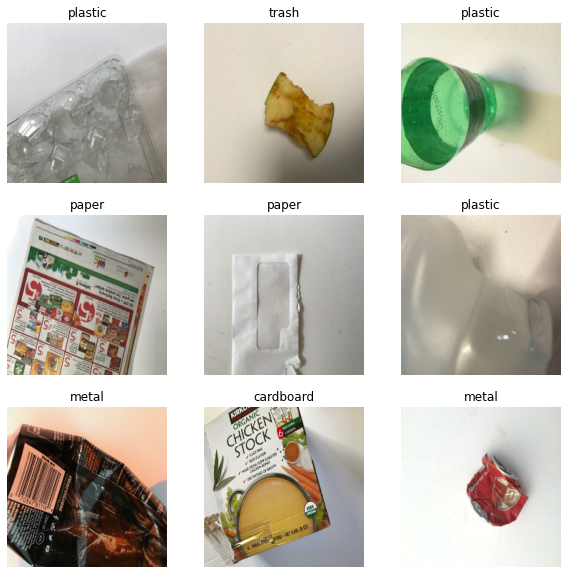

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
#train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess)
#test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
NUM_CLASSES

6

# Data augmentation

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Model training

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
epochs = 10 # @param {type: "slider", min:1, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/10


78/78 - 679s - loss: 2.9217 - accuracy: 0.2893 - val_loss: 1.7712 - val_accuracy: 0.2733 - 679s/epoch - 9s/step
Epoch 2/10
78/78 - 668s - loss: 2.0933 - accuracy: 0.3917 - val_loss: 1.9265 - val_accuracy: 0.2158 - 668s/epoch - 9s/step
Epoch 3/10
78/78 - 664s - loss: 1.8277 - accuracy: 0.4718 - val_loss: 2.0469 - val_accuracy: 0.2535 - 664s/epoch - 9s/step
Epoch 4/10
78/78 - 660s - loss: 1.5407 - accuracy: 0.5297 - val_loss: 2.3619 - val_accuracy: 0.2436 - 660s/epoch - 8s/step
Epoch 5/10
78/78 - 653s - loss: 1.2903 - accuracy: 0.5762 - val_loss: 1.8986 - val_accuracy: 0.2693 - 653s/epoch - 8s/step
Epoch 6/10


# Model evaluation